## Homework 6

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365','price'
]

target = 'price'

df = pd.read_csv('nyc.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [4]:
df['price'] = np.log1p(df[target])

In [5]:
target = df['price']
df.drop(columns= ['price'], inplace= True)

In [6]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,10,9,0.10,1,0


In [7]:
from sklearn.model_selection import train_test_split

# Split data
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

29337 29337
9779 9779


In [9]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = x_train.to_dict(orient= 'records')
train_dv = dv.fit_transform(train_dict)

val_dict = x_val.to_dict(orient= 'records')
val_dv = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [10]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth= 1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

> room_type=Entire home/apt

In [11]:
reg.fit(train_dv, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
imp_feature = np.argmax(reg.feature_importances_)

dv.get_feature_names()[imp_feature]

'room_type=Entire home/apt'

In [13]:
from sklearn.tree import export_text
print(export_text(reg, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state= 1, n_jobs= -1)

In [15]:
rf.fit(train_dv, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [17]:
y_pred = rf.predict(val_dv)

In [66]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_true= y_val, y_pred = y_pred, squared= True)
print(f'Validation RMSE: {round(rmse, 3)}')

Validation RMSE: 0.211


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

> Validation RMSE: 0.211 -> 0.259

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [23]:
def test_params(**params):
    """
    - Train a model with hyperparameter passed to function 
    - Predict  on validation set
    - Evaluate MSE
    """
    model = RandomForestRegressor(**params, random_state= 1).fit(train_dv, y_train)
    pred = model.predict(val_dv)
    val_rmse = mean_squared_error(y_val, pred,  squared=True)
    return val_rmse

def test_multiple_values(param_name, param_values):
    """
    For given param_name and range of values, train a model individually through function test_params
    and fetch-append validation RMSE
    """
    val_errors = []
    for value in param_values:
        params = {param_name: value}
        metric = test_params(**params)
        val_errors.append(round(metric, 5))
        print(f'Error evaluated for {param_name}')
    return val_errors

In [25]:
# Compile param values and rmse values together
estimators_range = [i for i in range(10, 201, 10)]
list(zip(estimators_range,(test_multiple_values('n_estimators', estimators_range))))

[(10, 0.211),
 (20, 0.201),
 (30, 0.198),
 (40, 0.196),
 (50, 0.196),
 (60, 0.195),
 (70, 0.194),
 (80, 0.194),
 (90, 0.194),
 (100, 0.193),
 (110, 0.193),
 (120, 0.193),
 (130, 0.193),
 (140, 0.193),
 (150, 0.193),
 (160, 0.193),
 (170, 0.193),
 (180, 0.193),
 (190, 0.193),
 (200, 0.193)]

In [26]:
rmse_list = [(10, 0.211),
 (20, 0.201),
 (30, 0.198),
 (40, 0.196),
 (50, 0.196),
 (60, 0.195),
 (70, 0.194),
 (80, 0.194),
 (90, 0.194),
 (100, 0.193),
 (110, 0.193),
 (120, 0.193),
 (130, 0.193),
 (140, 0.193),
 (150, 0.193),
 (160, 0.193),
 (170, 0.193),
 (180, 0.193),
 (190, 0.193),
 (200, 0.193)]

In [44]:
_, rmse = zip(*rmse_list)

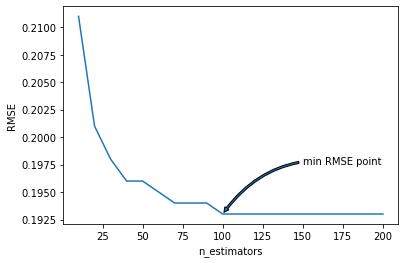

In [64]:
plot = plt.plot(estimators_range, rmse)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.annotate('min RMSE point',(100, 0.193), xytext = (150, 0.1975), arrowprops=dict(arrowstyle="simple"\
                        ,connectionstyle="arc3,rad=0.3"))
plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

> 100 (precision: 3 digits)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [68]:
scores = []

max_depth_range = [10, 15, 20, 25]

for depth in max_depth_range:
    print(f'Evaluating for max depth: {depth}')
    for num_estimators in estimators_range:
        rf = RandomForestRegressor(n_estimators=num_estimators,
                                    max_depth=depth,
                                    random_state=1)
        rf.fit(train_dv, y_train)
        y_pred = rf.predict(val_dv)
        rmse = mean_squared_error(y_val, y_pred, squared= True)
        print('.',sep="")
        scores.append((depth, num_estimators, rmse))
        

10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
10 100
10 110
10 120
10 130
10 140
10 150
10 160
10 170
10 180
10 190
10 200
15 10
15 20
15 30
15 40
15 50
15 60
15 70
15 80
15 90
15 100
15 110
15 120
15 130
15 140
15 150
15 160
15 170
15 180
15 190
15 200
20 10
20 20
20 30
20 40
20 50
20 60
20 70
20 80
20 90
20 100
20 110
20 120
20 130
20 140
20 150
20 160
20 170
20 180
20 190
20 200
25 10
25 20
25 30
25 40
25 50
25 60
25 70
25 80
25 90
25 100
25 110
25 120
25 130
25 140
25 150
25 160
25 170
25 180
25 190
25 200


In [69]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

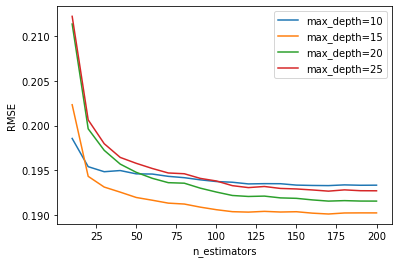

In [72]:
for d in max_depth_range:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth={d}')
    plt.xlabel('n_estimators')
    plt.ylabel('RMSE')

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

>15

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [73]:
forest5 = RandomForestRegressor(n_estimators=10, max_depth= 20, random_state= 1, n_jobs= -1)



In [74]:
forest5.fit(train_dv, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [75]:
imp_feature_q5 = np.argmax(forest5.feature_importances_)

dv.get_feature_names()[imp_feature_q5]

'room_type=Entire home/apt'

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

>room_type=Entire home/apt

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

